In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils, models
from torch.utils.data.dataloader import default_collate
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from timeit import default_timer as timer
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

from pathlib import Path
from google.colab import drive

In [2]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [ ]:
drive.mount('/content/drive/')
!cp /content/drive/MyDrive/GAN_data.csv /content/GAN_data.csv

Mounted at /content/drive/


###Data Preprocessing

In [3]:
df = pd.read_csv('/content/GAN_data.csv')
df.head()

,pixel_0000,pixel_0001,pixel_0002,pixel_0003,pixel_0004,pixel_0005,pixel_0006,pixel_0007,pixel_0008,pixel_0009,...,pixel_1015,pixel_1016,pixel_1017,pixel_1018,pixel_1019,pixel_1020,pixel_1021,pixel_1022,pixel_1023,character
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka


In [4]:
df = df.sample(frac=1)
df.head()

,pixel_0000,pixel_0001,pixel_0002,pixel_0003,pixel_0004,pixel_0005,pixel_0006,pixel_0007,pixel_0008,pixel_0009,...,pixel_1015,pixel_1016,pixel_1017,pixel_1018,pixel_1019,pixel_1020,pixel_1021,pixel_1022,pixel_1023,character
59988,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_30_motosaw
79344,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,digit_3
52175,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_27_ra
63458,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_32_patalosaw
83372,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,digit_5


In [5]:
NUM_CLASSES = df['character'].nunique()
print(NUM_CLASSES)

46


In [6]:
labels = df['character'].values

#LabelEncoding to convert labels to numbers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [7]:
label_encoder.classes_[0]

'character_01_ka'

In [8]:
print("Label mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{i}: {label}")

#Replacing the 'character' column in the df with the encoded labels
df['character'] = encoded_labels

Label mapping:
0: character_01_ka
1: character_02_kha
2: character_03_ga
3: character_04_gha
4: character_05_kna
5: character_06_cha
6: character_07_chha
7: character_08_ja
8: character_09_jha
9: character_10_yna
10: character_11_taamatar
11: character_12_thaa
12: character_13_daa
13: character_14_dhaa
14: character_15_adna
15: character_16_tabala
16: character_17_tha
17: character_18_da
18: character_19_dha
19: character_20_na
20: character_21_pa
21: character_22_pha
22: character_23_ba
23: character_24_bha
24: character_25_ma
25: character_26_yaw
26: character_27_ra
27: character_28_la
28: character_29_waw
29: character_30_motosaw
30: character_31_petchiryakha
31: character_32_patalosaw
32: character_33_ha
33: character_34_chhya
34: character_35_tra
35: character_36_gya
36: digit_0
37: digit_1
38: digit_2
39: digit_3
40: digit_4
41: digit_5
42: digit_6
43: digit_7
44: digit_8
45: digit_9


In [9]:
train_split = int(len(df)*0.8)

In [10]:
train_df = df[:train_split]
test_df = df[train_split:]

print(f"df len: {len(df)}\ntrain_df len: {len(train_df)}\ntest_df len: {len(test_df)}")

df len: 92000
train_df len: 73600
test_df len: 18400


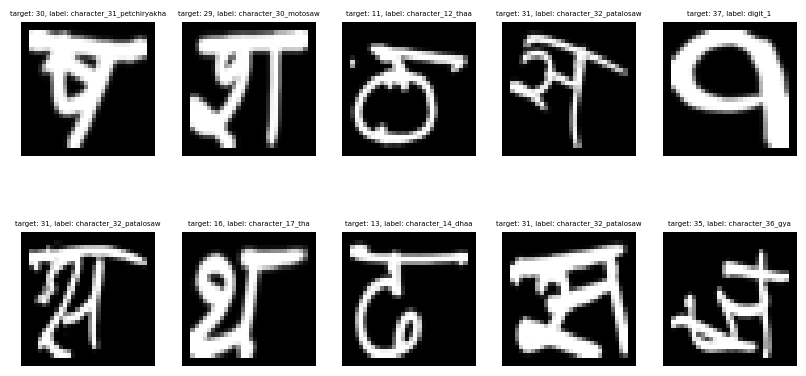

In [11]:
num_images = 10
num_cols = 5
num_rows = 2
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 5))

for i in range(num_images):
    r = np.random.randint(0, len(df))
    img = df.iloc[r, :-1]
    target = df.iloc[r, -1]
    label = label_encoder.classes_[target]
    img = np.array(img, dtype=np.float32)
    img = img.reshape((32, 32, 1))
    row = i // num_cols
    col = i % num_cols
    axs[row, col].imshow(img, cmap='gray')
    axs[row, col].set_title(f"target: {target}, label: {label}", fontsize = 5)
    axs[row, col].axis('off')

plt.show()

###Custom Dataset

In [12]:
class CustomDataset(Dataset):
    def __init__(self, df):
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((64, 64), antialias = False),
            transforms.Normalize((0.5,), (0.5,))
        ])

        self.img_ls = df.iloc[:, :-1].values.astype(np.float32)
        self.label_ls = label = df.iloc[:, -1]

        self.tensor_data_ls = []

        for img, label in zip(self.img_ls, self.label_ls):
          label = torch.tensor(label, dtype=torch.int64)
          img = img.reshape((32, 32)).astype(np.uint8)
          img = np.stack([img], axis=2)
          img = self.transform(img)

          self.tensor_data_ls.append((img, label))
          


    def __getitem__(self, index):

        # img = self.data.iloc[index, :-1].values.astype(np.float32)
        # label = self.data.iloc[index, -1]
        # label = torch.tensor(label, dtype=torch.int64)
        # img = img.reshape((32, 32)).astype(np.uint8)
        # img = np.stack([img], axis=2)
        #img = self.transform(img)
        img , label = self.tensor_data_ls[index]
        return img, label

    def __len__(self):
        return len(self.label_ls)

trainset = CustomDataset(train_df)
testset = CustomDataset(test_df)

del train_df, test_df

In [13]:
img, label = trainset.__getitem__(np.random.randint(0, len(trainset)))
img.shape, label.item(), label_encoder.classes_[label.item()], img.dtype, label.dtype

(torch.Size([1, 64, 64]), 44, 'digit_8', torch.float32, torch.int64)

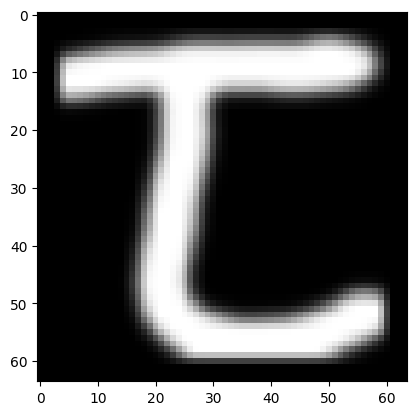

In [14]:
plt.imshow(img.reshape((64,64,1)), cmap = 'gray')

###Discriminator Model

In [15]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d, num_classes, img_size):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x img_size x img_size
            nn.Conv2d(channels_img + 1, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # output img: 4x4

            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            #output: 1x1
            nn.Sigmoid(),
        )

        self.embed = nn.Embedding(num_classes, img_size * img_size)

        self.img_size = img_size

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            # nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x, labels):
        embedding = self.embed(labels).view(labels.shape[0], 1, self.img_size, self.img_size)
        x = torch.cat([x, embedding], dim = 1) #batch, channel, img_size, img_size
        return self.disc(x)

###Generative Model

In [16]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g, num_classes, img_size, embed_size):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: batch x channels_noise x 1 x 1
            self._block(channels_noise + embed_size, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: batch x channels_img x 64 x 64
            nn.Tanh(),
        )

        self.embed = nn.Embedding(num_classes, embed_size)

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            # nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x, labels):
        #latent vector z: noise_dim, 1x1
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3)
        x = torch.cat([x, embedding], dim = 1)
        return self.net(x)

###Hyperparameters

In [17]:
BATCH_SIZE = 256

lr = 0.0002
beta1 = 0.5

EMBED_DIM = 100
LATENT_DIM = 100
IMAGE_SIZE = 64
CHANNELS_IMG = 1
NOISE_DIM = 100
NUM_EPOCHS = 50
FEATURES_DISC = 32
FEATURES_GEN = 32

In [18]:
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, drop_last = True, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, drop_last = True, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

In [19]:
generator = Generator(channels_noise = NOISE_DIM, 
                channels_img = CHANNELS_IMG, 
                features_g = FEATURES_GEN, 
                num_classes = NUM_CLASSES,
                img_size = IMAGE_SIZE,
                embed_size = EMBED_DIM,
                ).to(device)


discriminator = Discriminator(channels_img = CHANNELS_IMG, 
                              features_d = FEATURES_DISC,
                              num_classes = NUM_CLASSES,
                              img_size = IMAGE_SIZE
                              ).to(device)

In [20]:
# generator = Generator(latent_dim = latent_dim, num_classes = num_classes).to(device)
# discriminator = Discriminator(num_classes = num_classes).to(device)

opt_gen = optim.Adam(generator.parameters(), lr = lr, betas=(beta1, 0.999))
opt_disc = optim.Adam(discriminator.parameters(), lr = lr, betas=(beta1, 0.999))

loss_fn = nn.BCELoss()

In [21]:
fixed_noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)

###Training the cDCGAN

In [ ]:
gc.collect()
torch.cuda.empty_cache()


generator.train()
discriminator.train()

for epoch in range(1, NUM_EPOCHS+1):

  for batch_idx, (real, labels) in enumerate(train_loader):

    noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)

    fake = generator(noise, labels)

    ### Train Discriminator: max log(D(x)) + log(1 - D(G(z))) ###
    disc_real = discriminator(real, labels).reshape(-1)
    loss_disc_real = loss_fn(disc_real, torch.ones_like(disc_real))

    #disc_fake = discriminator(fake.detach(), labels).reshape(-1)
    disc_fake = discriminator(fake.detach(), labels).reshape(-1)
    loss_disc_fake = loss_fn(disc_fake, torch.zeros_like(disc_fake))

    loss_disc = (loss_disc_real + loss_disc_fake) / 2

    discriminator.zero_grad()
    loss_disc.backward()
    opt_disc.step()

    ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z)) ###
    output = discriminator(fake, labels).reshape(-1)
    loss_gen = loss_fn(output, torch.ones_like(output))
    generator.zero_grad()
    loss_gen.backward()
    opt_gen.step()

                
  print(f"Epochs: {epoch}/{NUM_EPOCHS} | Generator Loss: {loss_gen:0.4f} | Discriminator Loss: {loss_disc:0.4f}")

  del loss_disc, noise, fake, disc_real, loss_disc_real, disc_fake, loss_disc_fake, output, loss_gen
  gc.collect()
  torch.cuda.empty_cache()

Epochs: 1/50 | Generator Loss: 1.5296 | Discriminator Loss: 0.5951
Epochs: 2/50 | Generator Loss: 1.2222 | Discriminator Loss: 0.4958
Epochs: 3/50 | Generator Loss: 0.8308 | Discriminator Loss: 0.5331
Epochs: 4/50 | Generator Loss: 1.1134 | Discriminator Loss: 0.5750
Epochs: 5/50 | Generator Loss: 1.6867 | Discriminator Loss: 0.7346
Epochs: 6/50 | Generator Loss: 0.7765 | Discriminator Loss: 0.6429
Epochs: 7/50 | Generator Loss: 1.0800 | Discriminator Loss: 0.5967
Epochs: 8/50 | Generator Loss: 1.1116 | Discriminator Loss: 0.5928
Epochs: 9/50 | Generator Loss: 1.6082 | Discriminator Loss: 0.5828
Epochs: 10/50 | Generator Loss: 0.8432 | Discriminator Loss: 0.5558
Epochs: 11/50 | Generator Loss: 1.3789 | Discriminator Loss: 0.5550
Epochs: 12/50 | Generator Loss: 0.9074 | Discriminator Loss: 0.5689
Epochs: 13/50 | Generator Loss: 0.9085 | Discriminator Loss: 0.5563
Epochs: 14/50 | Generator Loss: 0.7636 | Discriminator Loss: 0.6574
Epochs: 15/50 | Generator Loss: 1.1187 | Discriminator Lo

###Save Models

In [ ]:
def save_model(MODEL_NAME, model: torch.nn.Module):

  MODEL_PATH = Path("/content")
  MODEL_PATH.mkdir(parents = True, exist_ok = True)

  MODEL_PATH_SAVE = MODEL_PATH / MODEL_NAME

  print(f"model saved at: {MODEL_PATH_SAVE}")
  torch.save(obj = model.state_dict(), f = MODEL_PATH_SAVE)

In [ ]:
save_model('discriminator.pt', discriminator)
save_model('generator.pt', generator)

model saved at: /content/discriminator.pt
model saved at: /content/generator.pt


###Load Models

In [22]:
generator = Generator(channels_noise = NOISE_DIM, 
                channels_img = CHANNELS_IMG, 
                features_g = FEATURES_GEN, 
                num_classes = NUM_CLASSES,
                img_size = IMAGE_SIZE,
                embed_size = EMBED_DIM,
                ).to(device)


# discriminator = Discriminator(channels_img = CHANNELS_IMG, 
#                               features_d = FEATURES_DISC,
#                               num_classes = NUM_CLASSES,
#                               img_size = IMAGE_SIZE
#                               ).to(device)

In [23]:
MODEL_PATH = Path("/content")

MODEL_NAME = "generator.pt"
MODEL_PATH_SAVE = MODEL_PATH / MODEL_NAME

if torch.cuda.is_available() == False:
  generator.load_state_dict(torch.load(f = MODEL_PATH_SAVE, map_location=torch.device('cpu')))
else:
  generator.load_state_dict(torch.load(f = MODEL_PATH_SAVE))

generator = generator.to(device)

In [24]:

# MODEL_PATH = Path("/content")

# MODEL_NAME = "discriminator.pt"
# MODEL_PATH_SAVE = MODEL_PATH / MODEL_NAME

# if torch.cuda.is_available() == False:
#   discriminator.load_state_dict(torch.load(f = MODEL_PATH_SAVE, map_location=torch.device('cpu')))
# else:
#   discriminator.load_state_dict(torch.load(f = MODEL_PATH_SAVE))

# discriminator = discriminator.to(device)

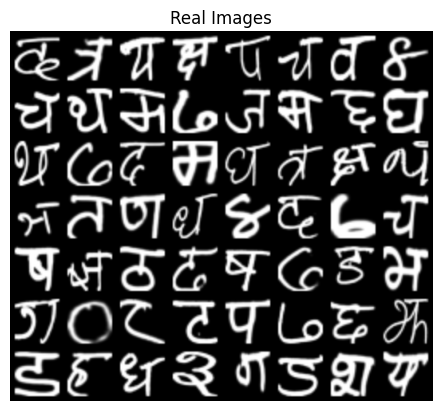

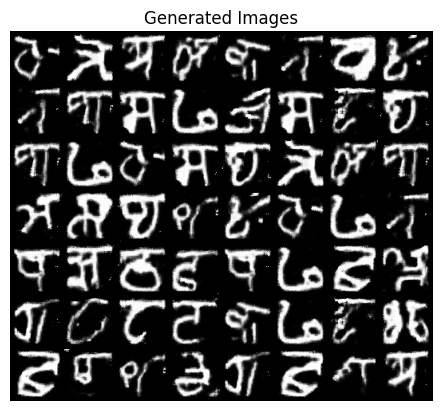

<Figure size 640x480 with 0 Axes>

In [25]:
for real, labels in test_loader:
  generator.eval()
  with torch.inference_mode():
      #noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
      fake = generator(fixed_noise, labels)
      img_grid_real = utils.make_grid(real[:56], normalize=True)
      img_grid_fake = utils.make_grid(fake[:56], normalize=True)
  break

plt.imshow(img_grid_real.permute(1, 2, 0).cpu().numpy())
plt.title('Real Images')
plt.axis('off')
plt.show()
plt.savefig('real_images.jpg')
plt.imshow(img_grid_fake.permute(1, 2, 0).cpu().numpy())
plt.title('Generated Images')
plt.axis('off')
plt.show()
plt.savefig('generated.jpg')

del img_grid_real, img_grid_fake

In [26]:
gc.collect()
torch.cuda.empty_cache()

###Create Dataset of Generated images

In [27]:
def generate_samples(label, generator):
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
        fake_images = generator(noise, label)
        fake_images = (fake_images + 1) / 2  # scale images from [-1, 1] to [0, 1]
        img_grid_fake = utils.make_grid(fake_images[:50], normalize=True)
        # plt.imshow(img_grid_fake.permute(1, 2, 0).cpu().numpy())
        # plt.title('Generated Images')
        # plt.axis('off')
        # plt.show()
    return fake_images

In [28]:
classes = df['character'].unique()

del df

samples_per_class = 50
generated_data = []
for class_label in classes:
    class_label = torch.tensor(class_label, dtype = torch.int64).to(device)
    class_label_stack = torch.stack([class_label]*BATCH_SIZE)
    
    fake_images = generate_samples(class_label_stack, generator)

    for i in range(samples_per_class):
      generated_data.append((fake_images[i], class_label))

    del fake_images, class_label_stack, class_label

len(generated_data), NUM_CLASSES * samples_per_class

(2300, 2300)

In [29]:
img, label = generated_data[0]
img.shape, label.item(), label_encoder.classes_[label.item()], img.dtype, label.dtype

(torch.Size([1, 64, 64]),
 29,
 'character_30_motosaw',
 torch.float32,
 torch.int64)

In [30]:
class GeneratedDataset(Dataset):
    def __init__(self, generated_data):
        self.generated_data = generated_data

    def __getitem__(self, index):
        return self.generated_data[index]

    def __len__(self):
        return len(self.generated_data)

generated_dataset = GeneratedDataset(generated_data)
generated_test_loader = DataLoader(generated_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

###Utils

In [31]:
def plot_graph(train_losses, test_losses, train_accs, test_accs):
  plt.figure(figsize = (20, 8))

  plt.subplot(1, 2, 1)
  plt.plot(range(len(train_losses)), train_losses, label = "Train Loss")
  plt.plot(range(len(test_losses)), test_losses, label = "Test Loss")
  plt.legend()
  plt.xlabel("Epoches")
  plt.ylabel("Loss")

  plt.subplot(1, 2, 2)
  plt.plot(range(len(train_accs)), train_accs, label = "Train Accuracy")
  plt.plot(range(len(test_accs)), test_accs, label = "Test Accuracy")
  plt.legend()
  plt.xlabel("Epoches")
  plt.ylabel("Accuracy")
  
  plt.show()

In [32]:
loss_fn = nn.CrossEntropyLoss().to(device)

def accuracy_fn(y_pred, y_true):
  return (((torch.eq(y_true, y_pred.argmax(dim = 1)).sum().item())/ len(y_pred))) * 100

In [33]:
def train(model, optimizer, loss_fn, epochs):
  
  epoch_ls = []
  test_loss_ls = []
  train_loss_ls = []
  train_acc_ls = []
  test_acc_ls = []

  for e in range(1, epochs+1):

    model.train()
    train_loss = 0
    train_acc = 0

    for batch, (X_train, y_train) in enumerate(train_loader):

      optimizer.zero_grad()
      y_pred = model(X_train)
      loss = loss_fn(y_pred, y_train)

      #print(f"running loss: {loss.item():.2f}")
      
      loss.backward()
      optimizer.step()

      train_loss = train_loss + loss
      train_acc = train_acc + accuracy_fn(y_pred, y_train)

      del loss

    train_loss = train_loss / len(train_loader)
    train_acc = train_acc / len(train_loader)
    
    model.eval()
    test_loss = 0
    test_acc = 0
    with torch.inference_mode():
      for X_test, y_test in generated_test_loader:
      
        test_pred = model(X_test)
        test_loss = test_loss + loss_fn(test_pred, y_test)
        test_acc = test_acc + accuracy_fn(test_pred, y_test)

    test_loss = test_loss / len(generated_test_loader)
    test_acc = test_acc / len(generated_test_loader)

    print(f"Epochs: {e} | Train Loss: {train_loss:0.2f} | Train Accuracy: {train_acc:0.2f} | Test Loss: {test_loss:0.2f} | Test Accuracy: {test_acc:0.2f}")

    test_loss_ls.append(test_loss)
    train_loss_ls.append(train_loss)
    test_acc_ls.append(test_acc)
    train_acc_ls.append(train_acc)

    del test_loss, train_loss, test_acc, train_acc, y_pred, test_pred
    if device == torch.device("cuda"):
      gc.collect()
      torch.cuda.empty_cache()
  
  train_loss_ls = torch.tensor(train_loss_ls).cpu().numpy()
  test_loss_ls = torch.tensor(test_loss_ls).cpu().numpy()
  train_acc_ls = torch.tensor(train_acc_ls).cpu().numpy()
  test_acc_ls = torch.tensor(test_acc_ls).cpu().numpy()
  
  return train_loss_ls, test_loss_ls, train_acc_ls, test_acc_ls

    

###Training Resnet18

In [34]:
resnet18 = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1, progress = False).to(device)
resnet18.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False).to(device)
feature_number = resnet18.fc.in_features
resnet18.fc = nn.Linear(feature_number, NUM_CLASSES).to(device)

epochs = 7
optimizer = optim.Adam(resnet18.parameters(), lr = 0.001)

In [35]:
train_loss_ls, test_loss_ls, train_acc_ls, test_acc_ls = train(resnet18, optimizer, loss_fn, epochs)

Epochs: 1 | Train Loss: 0.23 | Train Accuracy: 93.68 | Test Loss: 5.47 | Test Accuracy: 13.04
Epochs: 2 | Train Loss: 0.06 | Train Accuracy: 98.19 | Test Loss: 6.08 | Test Accuracy: 15.22
Epochs: 3 | Train Loss: 0.04 | Train Accuracy: 98.74 | Test Loss: 4.11 | Test Accuracy: 23.95
Epochs: 4 | Train Loss: 0.03 | Train Accuracy: 99.18 | Test Loss: 2.83 | Test Accuracy: 36.79
Epochs: 5 | Train Loss: 0.03 | Train Accuracy: 99.12 | Test Loss: 3.74 | Test Accuracy: 36.40
Epochs: 6 | Train Loss: 0.03 | Train Accuracy: 99.23 | Test Loss: 4.10 | Test Accuracy: 30.44
Epochs: 7 | Train Loss: 0.02 | Train Accuracy: 99.33 | Test Loss: 3.65 | Test Accuracy: 30.48


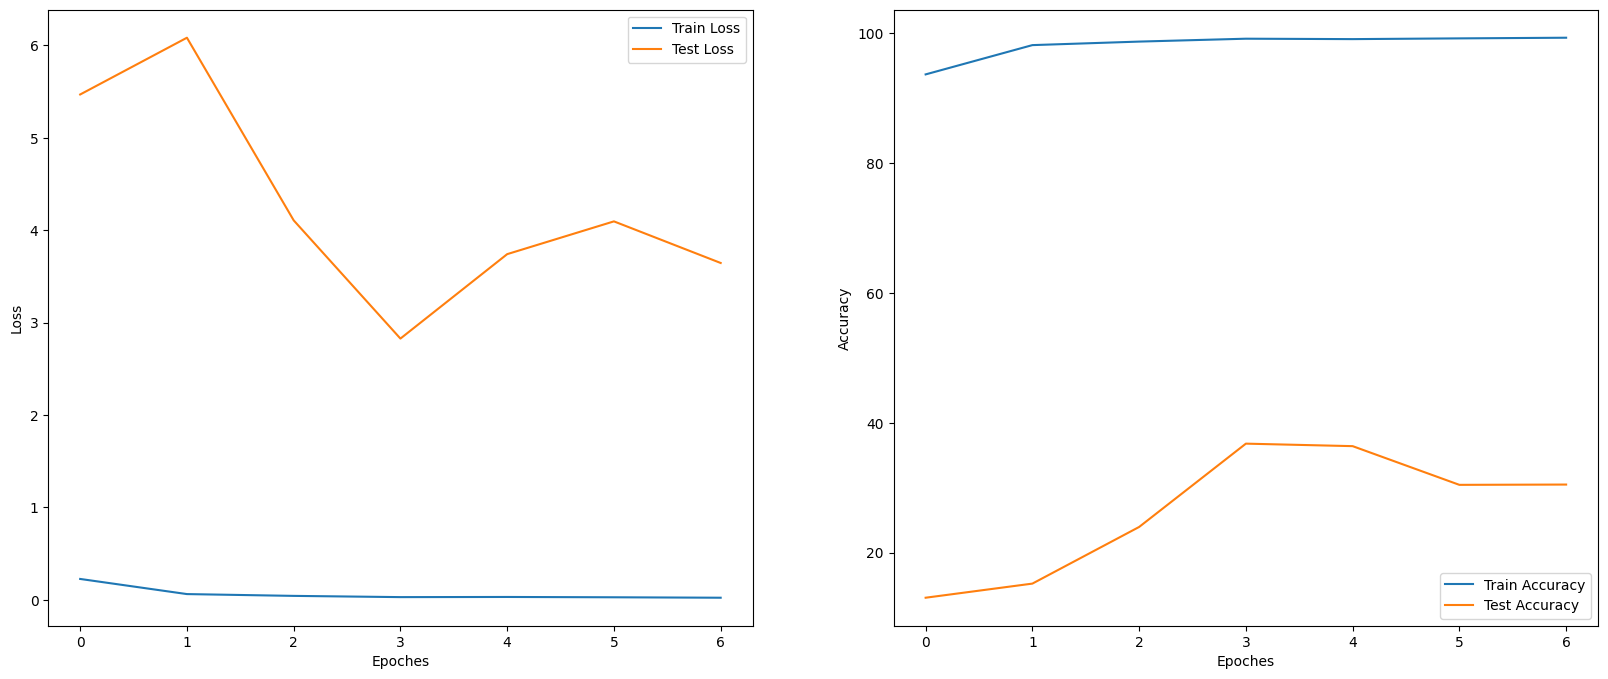

In [36]:
plot_graph(train_loss_ls, test_loss_ls, train_acc_ls, test_acc_ls)

In [46]:
y_pred = []
y_true = []

with torch.inference_mode():
    for X_test, y_test in generated_test_loader:

      test_pred = resnet18(X_test)
      y_pred.extend(test_pred.argmax(dim = 1).cpu().numpy())
      y_true.extend(y_test.cpu().numpy())

###F1 Score

In [66]:
print(f"f1_score: {f1_score(y_pred, y_true, average='macro'): 0.3f}")

f1_score:  0.208


###Confusion Matrix

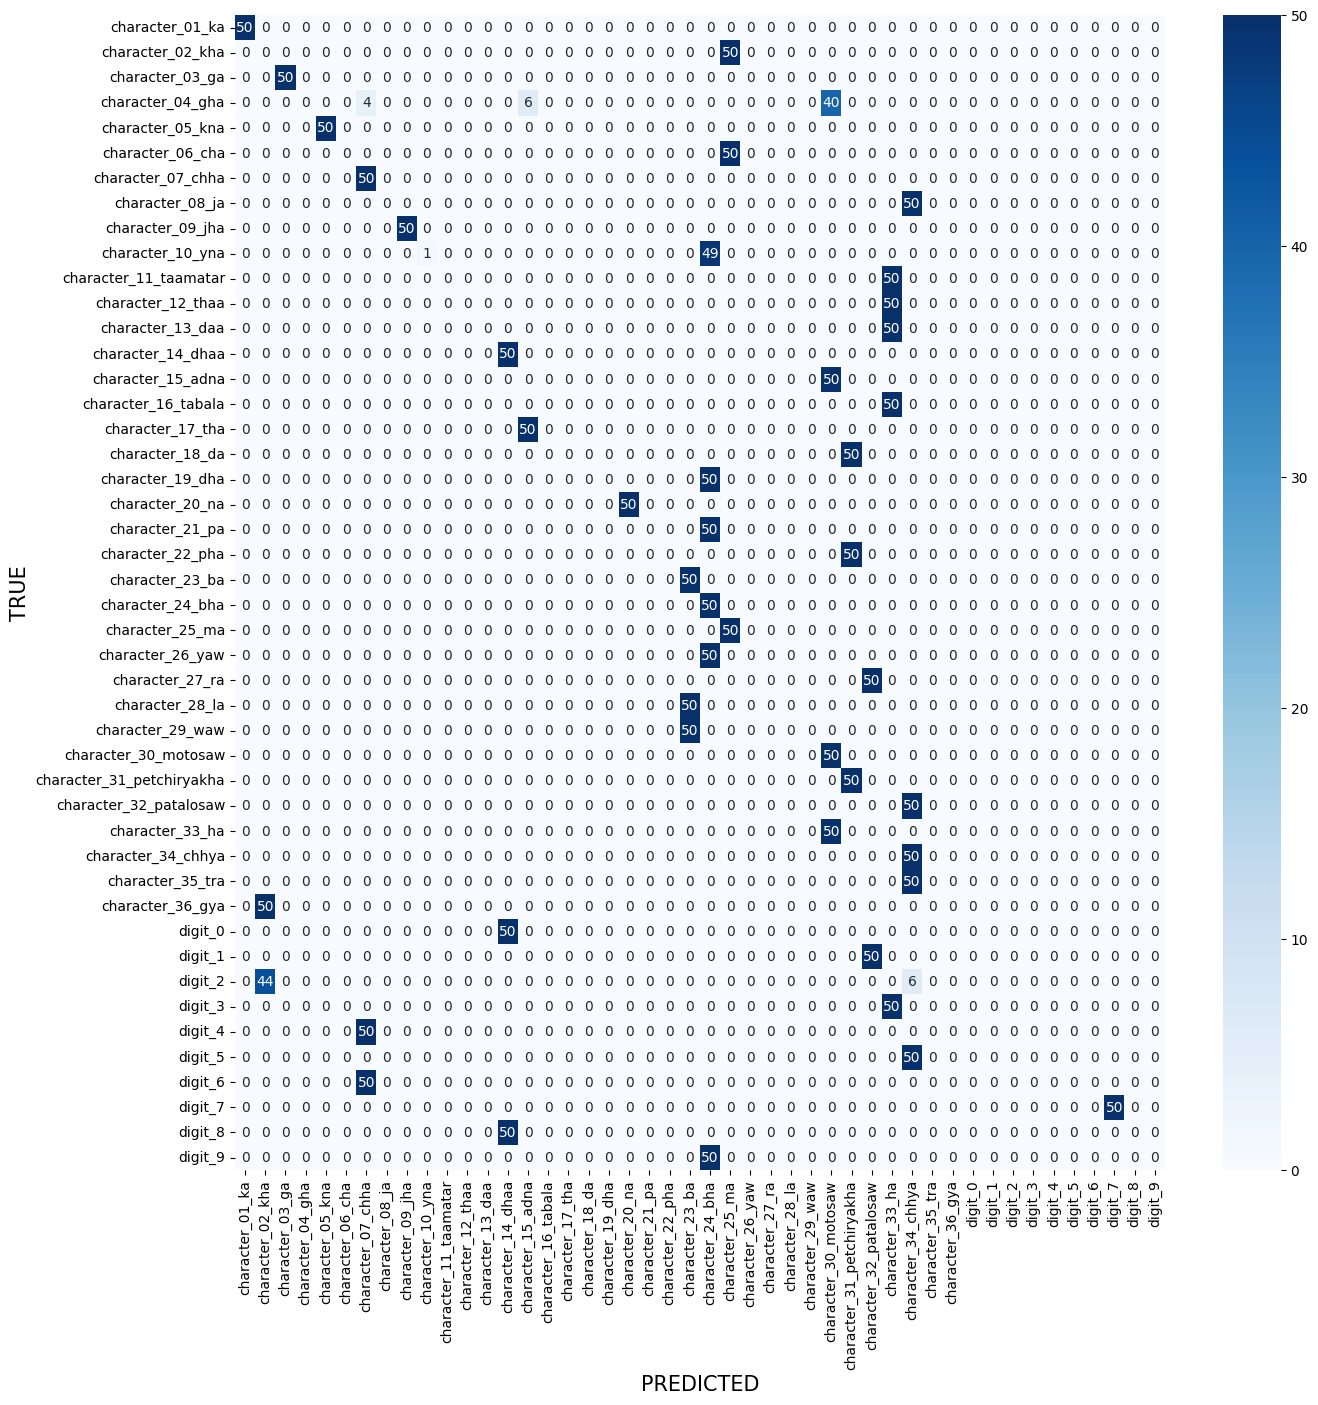

In [65]:
mat = confusion_matrix(y_true, y_pred)

class_names = label_encoder.classes_

fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(mat, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)

plt.xlabel('PREDICTED', fontsize = 15)
plt.ylabel('TRUE', fontsize = 15)

plt.show()